<a href="https://colab.research.google.com/github/hamzachikhaoui2/MECH501/blob/main/Assignment2_MECH_501_Part_2_HamzaChikhaoui.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MECH 501 Assignment 2 :
## *Can convolutional neural networks (CNNs) be used for defect detection and identification on screws in a few shot learning environment ?*
**Part 2  :**  Development of a CNN architecture tailored to few-shot learning environment.

In this section of the report, we will be investiguating how the use of a neural network specifically pre-trained for few shot learning tasks will impact the accuracy of our model.
However, to do so, the architecture of the model and its setup will vary from one of a classic neural network.

#Imports


In [ ]:
# Dependencies Part 2
!pip install pillow==8.3.1
!pip install tqdm==4.62.3
!pip install pytorch-lightning==1.4.9
!pip install seaborn==0.11.2
!pip install ipython==7.28.0


ERROR: Could not find a version that satisfies the requirement imghdr (from versions: none)
ERROR: No matching distribution found for imghdr


In [ ]:
import tensorflow as tf
import os
from google.colab import drive
import matplotlib.pyplot as plt
import cv2
import imghdr
import numpy as np
from tensorflow import keras
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing import image
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy
from sklearn.metrics import classification_report
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.image import grayscale_to_rgb
import random
import json
from PIL import Image
from collections import defaultdict
from statistics import mean, stdev
from copy import deepcopy

## Imports for plotting
import matplotlib.pyplot as plt
plt.set_cmap('cividis')
%matplotlib inline
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg', 'pdf') # For export
import matplotlib
matplotlib.rcParams['lines.linewidth'] = 2.0
import seaborn as sns
sns.reset_orig()
from tqdm.auto import tqdm

## PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torch.optim as optim

## Torchvision
import torchvision
from torchvision import transforms
from torch.utils import data

# PyTorch Lightning
try:
    import pytorch_lightning as pl
except ModuleNotFoundError:
    !pip install --quiet pytorch-lightning>=1.4
    import pytorch_lightning as pl
from pytorch_lightning.callbacks import LearningRateMonitor, ModelCheckpoint

from torch.utils.data import Dataset
# Setting the seed
pl.seed_everything(42)
import seaborn as sns



<ipython-input-1-710e87b809da>:33: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('svg', 'pdf') # For export
INFO:lightning_fabric.utilities.seed:Seed set to 42


<Figure size 640x480 with 0 Axes>


Set up GPU if available:


In [ ]:
#Loading images

device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
print("Device:", device)

gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

tf.config.list_physical_devices('GPU')



Device: cpu


[]

For this part of the report, we will be implementing some neural networks specifically pretrained for few shot learning environments. To do so, we will download these specific pretrained neural networks from a github repository on internet.

The ressources used for this section have been tailored for our specific problematic, and are available in the references section of this report [4].

In [ ]:
import urllib.request
from urllib.error import HTTPError

#There is no need to update any link in this cell.

base_url = "https://raw.githubusercontent.com/phlippe/saved_models/main/tutorial16/"
# Files to download
pretrained_files = ["ProtoNet.ckpt", "ProtoMAML.ckpt",
                    "tensorboards/ProtoNet/events.out.tfevents.ProtoNet",
                    "tensorboards/ProtoMAML/events.out.tfevents.ProtoMAML",
                    "protomaml_fewshot.json",
                    "protomaml_svhn_fewshot.json"]

CHECKPOINT_PATH = "../saved_models/tutorial16"

# Create checkpoint paths did not work
os.makedirs(CHECKPOINT_PATH, exist_ok=True)

# For each file, check if the file is already downloaded. If not, download it.
for file_name in pretrained_files:
    file_path = os.path.join(CHECKPOINT_PATH, file_name)
    if "/" in file_name:
        os.makedirs(file_path.rsplit("/",1)[0], exist_ok=True)
    if not os.path.isfile(file_path):
        file_url = base_url + file_name
        print(f"Downloading {file_url}...")
        try:
            urllib.request.urlretrieve(file_url, file_path)
        except HTTPError as e:
            print("Something went wrong. Please try to download the file from the GDrive folder, or contact the author with the full output including the following error:\n", e)

# Further Set-up : creation of a custom infrastructure for our dataset


As a standard operation in the implementation of few-shot learning algorithms, we will be creating some custom datastructures to store the images from our set.

These images will first be processed, their size reduced, then transformed to add noise in the training data set.



In [ ]:
class CustomDataset(data.Dataset):
    def __init__(self, imgs, targets, img_transform=None):
        """
        Inputs:
            N = number of samples in our training set (138)
            imgs - Numpy array of shape [N,32,32,3] containing all images.
            targets - PyTorch array of shape [N] containing all labels.
            img_transform - A torchvision transformation that should be applied
                            to the images before returning. If none, no transformation
                            is applied.
        """
        super().__init__()
        self.img_transform = img_transform
        self.imgs = imgs
        self.targets = targets

    def __getitem__(self, idx):
        img, target = self.imgs[idx], self.targets[idx]
        img = Image.fromarray(img)

        if self.img_transform is not None:
            img = self.img_transform(img)

        return img, target

    def __len__(self):
        return self.imgs.shape[0]
    def __getitem__(self, idx):
        img, target = self.imgs[idx], self.targets[idx]

        # Convert the image to RGB mode
        img = Image.fromarray(img.astype(np.uint8))  # Ensure uint8 format
        img = img.convert("RGB")

        if self.img_transform is not None:
            img = self.img_transform(img)

        return img, target

    def __len__(self):
        return len(self.imgs)



class FewShotBatchSampler(object):

    def __init__(self, dataset_targets, N_way, K_shot, include_query=False, shuffle=True, shuffle_once=False):
        """
        Inputs:
            dataset_targets - PyTorch tensor of the labels of the data elements.
            N_way - Number of classes to sample per batch. Here 6.
            K_shot - Number of examples to sample per class in the batch. Here, we will be harmonizing our dataset
            by selecting 23 samples per class.
            include_query - If True, returns batch of size N_way*K_shot*2, which
                            can be split into support and query set. Simplifies
                            the implementation of sampling the same classes but
                            distinct examples for support and query set.
            shuffle - If True, examples and classes are newly shuffled in each
                      iteration (for training)
            shuffle_once - If True, examples and classes are shuffled once in
                           the beginning, but kept constant across iterations
                           (for validation)
        """
        super().__init__()
        self.dataset_targets = dataset_targets
        self.N_way = N_way
        self.K_shot = K_shot
        self.shuffle = shuffle
        self.include_query = include_query
        if self.include_query:
            self.K_shot *= 2
        self.batch_size = self.N_way * self.K_shot  # Number of overall images per batch

        # Organize examples by class
        self.classes = torch.unique(self.dataset_targets).tolist()
        self.num_classes = len(self.classes)
        self.indices_per_class = {}
        self.batches_per_class = {}  # Number of K-shot batches that each class can provide
        for c in self.classes:
            self.indices_per_class[c] = torch.where(self.dataset_targets == c)[0]
            self.batches_per_class[c] = self.indices_per_class[c].shape[0] // self.K_shot

        # Create a list of classes from which we select the N classes per batch
        self.iterations = sum(self.batches_per_class.values()) // self.N_way
        self.class_list = [c for c in self.classes for _ in range(self.batches_per_class[c])]
        if shuffle_once or self.shuffle:
            self.shuffle_data()
        else:
            # For testing, we iterate over classes instead of shuffling them
            sort_idxs = [i+p*self.num_classes for i,
                         c in enumerate(self.classes) for p in range(self.batches_per_class[c])]
            self.class_list = np.array(self.class_list)[np.argsort(sort_idxs)].tolist()

    def shuffle_data(self):
        # Shuffle the examples per class
        for c in self.classes:
            perm = torch.randperm(self.indices_per_class[c].shape[0])
            self.indices_per_class[c] = self.indices_per_class[c][perm]
        # Shuffle the class list from which we sample. Note that this way of shuffling
        # does not prevent to choose the same class twice in a batch. However, for
        # training and validation, this is not a problem.
        random.shuffle(self.class_list)

    def __iter__(self):
        # Shuffle data
        if self.shuffle:
            self.shuffle_data()

        # Sample few-shot batches
        start_index = defaultdict(int)
        for it in range(self.iterations):
            class_batch = self.class_list[it*self.N_way:(it+1)*self.N_way]  # Select N classes for the batch
            index_batch = []
            for c in class_batch:  # For each class, select the next K examples and add them to the batch
                index_batch.extend(self.indices_per_class[c][start_index[c]:start_index[c]+self.K_shot])
                start_index[c] += self.K_shot
            if self.include_query:  # If we return support+query set, sort them so that they are easy to split
                index_batch = index_batch[::2] + index_batch[1::2]
            yield index_batch

    def __len__(self):
        return self.iterations




In [ ]:
def split_batch(imgs, targets): #Method to split the batch
    support_imgs, query_imgs = imgs.chunk(2, dim=0)
    support_targets, query_targets = targets.chunk(2, dim=0)
    return support_imgs, query_imgs, support_targets, query_targets


def get_convnet(output_size):
    convnet = torchvision.models.DenseNet(growth_rate=32,
                                          block_config=(6, 6, 6, 6),
                                          bn_size=2,
                                          num_init_features=64,
                                          num_classes=output_size  # Output dimensionality
                                         )
    return convnet



def load_images_from_classes(root_folder):
    #Iitializing an array of images
    all_images = []

    for class_folder in os.listdir(root_folder):
      #We iterate over all subfolders inside the training folder
        class_path = os.path.join(root_folder, class_folder)
        #If the path selected is the path to a directory
        if os.path.isdir(class_path):
            for filename in os.listdir(class_path):
              #for every file inside of that directory (i.e. for every picture in that class)
                if filename.endswith(('.png', '.jpg', '.jpeg')):
                  #image_path is the path to that specific image
                    image_path = os.path.join(class_path, filename)

                    # Open image and convert it to a NumPy array
                    img = Image.open(image_path).resize((32,32))
                    img_array = np.array(img)

                    # Append the array to the list
                    all_images.append(img_array)

    return all_images

#Load the data

In [ ]:
from PIL import Image
import numpy as np
import os


train_path = '/content/drive/MyDrive/Data sets assignment 2/TRAIN'  #Path to the training data -- to be updated


#Small modification form the previous experiments, here we will harmonize the dataset by selecting the same number of samples for each class.
#Here, is 23 samples per class.

all_images = np.array(load_images_from_classes(train_path))

print(f"Number of images: {len(all_images)}")
print(f"type: {type(all_images)}")



Number of images: 138
type: <class 'numpy.ndarray'>


'''
Expected output :
Number of images: 138
type: <class 'numpy.ndarray'>'''

In [ ]:
import os
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from PIL import Image


# We here define the paths to validation and training sets.


# Define the data transforms
data_transform = transforms.Compose([
    transforms.Resize((32, 32)), #We resize the images to only focus on the differentiating features, and
    #keep the running times of our model manageable.
    transforms.ToTensor(),
])

# Check if the directories exist.
if not os.path.exists(train_path):
    raise FileNotFoundError(f"Directory not found: {train_path}")


# We here create a custom dataset to extract the labels from the training dataset.
custom_dataset = ImageFolder(root=train_path, transform=data_transform)
all_targets = torch.LongTensor([label for _, label in custom_dataset])

# Example usage:
print(f"Number of images: {len(all_images)}")
print(f"Number of labels: {len(all_targets)}")

Number of images: 138
Number of labels: 138


Expected Output :

Number of images: 138

Number of labels: 138


#Start of the implementation of the few-shot learning model


Unlike the previous models that we ran, the implementation of a few shot learning model is sensibly different.
- Instead of selecting a certain amount of samples per classes, here the goal will be to accurately predict the class of 1 sample.
This is the structure of a few shot model:
- A training set called "the support set", that contains:
    - N class labels (at most 6 in our case)
    - K labeled images for each class (at most 20 samples for our case)
    - Some query images.

The following image sums up this architecture for the dataset:
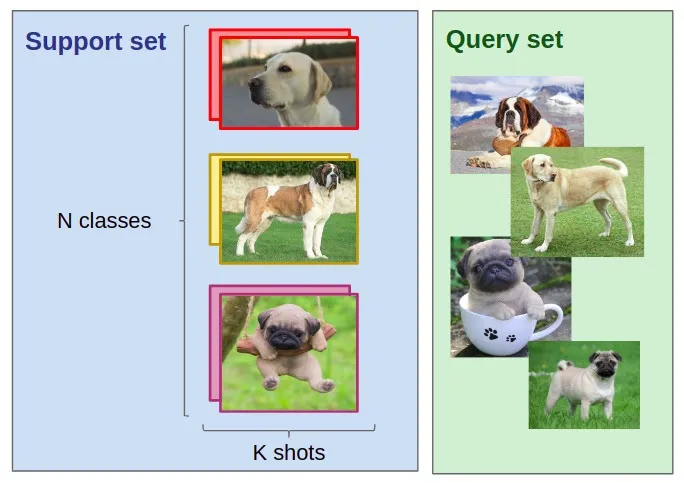


Therefore, in the following cells, we will be selecting which classes we will be using for training, and which ones will we use for validaiton.
However, because we only have very few classes to choose from (6), we will simply always select all classes for training, validation, and testing.

In [ ]:
classes = torch.randperm(6)
val_classes, test_classes, train_classes = classes[:], classes[:], classes[:]

idx_to_class = {val: key for key, val in custom_dataset.class_to_idx.items()}
print("Validation classes:", [idx_to_class[c.item()] for c in val_classes])
print("Test classes:", [idx_to_class[c.item()] for c in test_classes])

Validation classes: ['thread_top', 'manipulated_front', 'scratch_head', 'thread_side', 'good', 'scratch_neck']
Test classes: ['thread_top', 'manipulated_front', 'scratch_head', 'thread_side', 'good', 'scratch_neck']


In [ ]:
#For the selected classes established above, find generate a custom dataset with the corresponding images
def dataset_from_labels(imgs, targets, class_set, **kwargs):
    class_mask = (targets[:,None] == class_set[None,:]).any(dim=-1)
    #Return an instance of our customDataset with the correct the images for the given class.
    return CustomDataset(imgs=imgs[class_mask],
                        targets=targets[class_mask],
                        **kwargs)

In [ ]:
#Normalizing the datasets by substracting the mean and dividing by the standard deviation for each image
DATA_MEANS = torch.Tensor([0.5, 0.5, 0.5])
DATA_STD = torch.Tensor([0.5, 0.5, 0.5])

#We crop our images into 32x32 images to make the process less timely and get rid of unnecessary features
test_transform = transforms.Compose([transforms.ToTensor(),
                                     transforms.RandomResizedCrop(
                                          (32, 32)),
                                     transforms.Normalize(
                                         DATA_MEANS, DATA_STD)
                                     ])

# For training, we add some augmentation.
train_transform = transforms.Compose([transforms.RandomHorizontalFlip(),
                                      transforms.RandomResizedCrop(
                                          (32, 32), scale=(0.8, 1.0), ratio=(0.9, 1.1)),
                                      transforms.ToTensor(),
                                      transforms.Normalize(
                                          DATA_MEANS, DATA_STD)
                                      ])


train_set = dataset_from_labels(
    all_images, all_targets, train_classes, img_transform=train_transform)
val_set = dataset_from_labels(
    all_images, all_targets, val_classes, img_transform=test_transform)
test_set = dataset_from_labels(
    all_images, all_targets, test_classes, img_transform=test_transform)


# Print the number of classes in each set
print(f"Number of classes in the training set: {len(train_set)}")
print(f"Number of classes in the validation set: {len(val_set)}")
print(f"Number of classes in the test set: {len(test_set)}")

print(f"Type in the training set: {type(train_set)}")
print(f"Type in the validation set: {type(val_set)}")
print(f"Type in the test set: {type(test_set)}")


Number of classes in the training set: 138
Number of classes in the validation set: 138
Number of classes in the test set: 138
Type in the training set: <class '__main__.CustomDataset'>
Type in the validation set: <class '__main__.CustomDataset'>
Type in the test set: <class '__main__.CustomDataset'>


Expected output:

Number of classes in the training set: 138

Number of classes in the validation set: 138

Number of classes in the test set: 138

Type in the training set: <class '__main__.CustomDataset'>

Type in the validation set: <class '__main__.CustomDataset'>

Type in the test set: <class '__main__.CustomDataset'>

In [ ]:
N_WAY = 6 #6 class classification problem
K_SHOT = 23 #for now, Let us start with 2 samples per class
train_data_loader = data.DataLoader(train_set,
                                    batch_sampler=FewShotBatchSampler(train_set.targets,
                                                                      include_query=True,
                                                                      N_way=N_WAY,
                                                                      K_shot=K_SHOT,
                                                                      shuffle=True),
                                    num_workers=4)
val_data_loader = data.DataLoader(val_set,
                                  batch_sampler=FewShotBatchSampler(val_set.targets,
                                                                    include_query=True,
                                                                    N_way=N_WAY,
                                                                    K_shot=K_SHOT,
                                                                    shuffle=False,
                                                                    shuffle_once=True),
                                  num_workers=4)

# The number of workers was iterated and the selected one (4) was the one achieving the highest accuracy.

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


#Train Module

To train the model, we will be using a pre-trained meta-learner named ProtoNet.

This meta learner is different from previously implemented pre-trained models in that it was not trained to detect existing patterns from an already existing dataset. It was however trained to recognize similarities between samples.

Essentially what this learner does is that when presented one sample image from the query set, this learner will identify to which class from the support set this sample is the closest.

An analogy to what this learner does would be that the learner is trained to recognize how similar are two images, as opposed to detecting if each image contains a pattern for which it would have been previously trained.

This interesting caracteristic allows this learner to classify (to a certain extent) some images even if it had never been trained on any remotely similar image, but simply based on how similar that image is to the "support set" it was fed.



In [ ]:
class ProtoNet(pl.LightningModule):

    def __init__(self, proto_dim, lr):
        """
        Inputs
            proto_dim - Dimensionality of prototype feature space
            lr - Learning rate of Adam optimizer
        """
        super().__init__()
        self.save_hyperparameters()
        self.model = get_convnet(output_size=self.hparams.proto_dim)

    def configure_optimizers(self):
        optimizer = optim.AdamW(self.parameters(), lr=self.hparams.lr)
        scheduler = optim.lr_scheduler.MultiStepLR(
            optimizer, milestones=[140, 180], gamma=0.1)
        return [optimizer], [scheduler]

    @staticmethod
    def calculate_prototypes(features, targets):
        # Given a stack of features vectors and labels, return class prototypes
        # features - shape [N, proto_dim], targets - shape [N]
        classes, _ = torch.unique(targets).sort()  # Determine which classes we have
        prototypes = []
        for c in classes:
            p = features[torch.where(targets == c)[0]].mean(dim=0)  # Average class feature vectors
            prototypes.append(p)
        prototypes = torch.stack(prototypes, dim=0)
        # Return the 'classes' tensor to know which prototype belongs to which class
        return prototypes, classes

    def classify_feats(self, prototypes, classes, feats, targets):
        # Classify new examples with prototypes and return classification error
        dist = torch.pow(prototypes[None, :] - feats[:, None], 2).sum(dim=2)  # Squared euclidean distance
        preds = F.log_softmax(-dist, dim=1)
        labels = (classes[None, :] == targets[:, None]).long().argmax(dim=-1)
        acc = (preds.argmax(dim=1) == labels).float().mean()
        return preds, labels, acc

    def calculate_loss(self, batch, mode):
        # Determine training loss for a given support and query set
        imgs, targets = batch
        features = self.model(imgs)  # Encode all images of support and query set
        support_feats, query_feats, support_targets, query_targets = split_batch(features, targets)
        prototypes, classes = ProtoNet.calculate_prototypes(support_feats, support_targets)
        preds, labels, acc = self.classify_feats(prototypes, classes, query_feats, query_targets)
        loss = F.cross_entropy(preds, labels)

        self.log(f"{mode}_loss", loss)
        self.log(f"{mode}_acc", acc)
        return loss

    def training_step(self, batch, batch_idx):
        return self.calculate_loss(batch, mode="train")

    def validation_step(self, batch, batch_idx):
        _ = self.calculate_loss(batch, mode="val")

In [ ]:
def train_model(model_class, train_loader, val_loader, **kwargs):
    trainer = pl.Trainer(default_root_dir=os.path.join(CHECKPOINT_PATH, model_class.__name__),
                         accelerator="gpu" if str(device).startswith("cuda") else "cpu",
                         devices=1,
                         max_epochs=200,
                         callbacks=[ModelCheckpoint(save_weights_only=True, mode="max", monitor="val_acc"),
                                    LearningRateMonitor("epoch")],
                         enable_progress_bar=False)
    trainer.logger._default_hp_metric = None

    # Check whether pretrained model exists. If yes, load it and skip training
    pretrained_filename = os.path.join(CHECKPOINT_PATH, model_class.__name__ + ".ckpt")
    if os.path.isfile(pretrained_filename):
        print(f"Found pretrained model at {pretrained_filename}, loading...")
        # Automatically loads the model with the saved hyperparameters
        model = model_class.load_from_checkpoint(pretrained_filename)
    else:
        pl.seed_everything(42)  # To be reproducible
        model = model_class(**kwargs)
        trainer.fit(model, train_loader, val_loader)
        model = model_class.load_from_checkpoint(
            trainer.checkpoint_callback.best_model_path
        )  # Load the best checkpoint after training

    return model


In [ ]:
protonet_model = train_model(ProtoNet,
                             proto_dim=64,
                             lr=2e-4,
                             train_loader=train_data_loader,
                             val_loader=val_data_loader)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.utilities.migration.utils:Lightning automatically upgraded your loaded checkpoint from v1.3.4 to v2.1.2. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint ../saved_models/tutorial16/ProtoNet.ckpt`


Found pretrained model at ../saved_models/tutorial16/ProtoNet.ckpt, loading...


In [ ]:
@torch.no_grad()
def test_proto_net(model, dataset, data_feats=None, k_shot=4):
    """
    Inputs
        model - Pretrained ProtoNet model
        dataset - The dataset on which the test should be performed.
                  Should be instance of ImageDataset
        data_feats - The encoded features of all images in the dataset.
                     If None, they will be newly calculated, and returned
                     for later usage.
        k_shot - Number of examples per class in the support set.
    """
    model = model.to(device)
    model.eval()
    num_classes = dataset.targets.unique().shape[0]
    exmps_per_class = dataset.targets.shape[0]//num_classes  # We assume uniform example distribution here

    # The encoder network remains unchanged across k-shot settings. Hence, we only need
    # to extract the features for all images once.
    if data_feats is None:
        # Dataset preparation
        dataloader = data.DataLoader(dataset, batch_size=128, num_workers=4, shuffle=False, drop_last=False)

        img_features = []
        img_targets = []
        for imgs, targets in tqdm(dataloader, "Extracting image features", leave=False):
            imgs = imgs.to(device)
            feats = model.model(imgs)
            img_features.append(feats.detach().cpu())
            img_targets.append(targets)
        img_features = torch.cat(img_features, dim=0)
        img_targets = torch.cat(img_targets, dim=0)
        # Sort by classes, so that we obtain tensors of shape [num_classes, exmps_per_class, ...]
        # Makes it easier to process later
        img_targets, sort_idx = img_targets.sort()
        img_targets = img_targets.reshape(num_classes, exmps_per_class).transpose(0, 1)
        img_features = img_features[sort_idx].reshape(num_classes, exmps_per_class, -1).transpose(0, 1)
    else:
        img_features, img_targets = data_feats

    # We iterate through the full dataset in two manners. First, to select the k-shot batch.
    # Second, the evaluate the model on all other examples
    accuracies = []
    for k_idx in tqdm(range(0, img_features.shape[0], k_shot), "Evaluating prototype classification", leave=False):
        # Select support set and calculate prototypes
        k_img_feats, k_targets = img_features[k_idx:k_idx+k_shot].flatten(0,1), img_targets[k_idx:k_idx+k_shot].flatten(0,1)
        prototypes, proto_classes = model.calculate_prototypes(k_img_feats, k_targets)
        # Evaluate accuracy on the rest of the dataset
        batch_acc = 0
        for e_idx in range(0, img_features.shape[0], k_shot):
            if k_idx == e_idx:  # Do not evaluate on the support set examples
                continue
            e_img_feats, e_targets = img_features[e_idx:e_idx+k_shot].flatten(0,1), img_targets[e_idx:e_idx+k_shot].flatten(0,1)
            _, _, acc = model.classify_feats(prototypes, proto_classes, e_img_feats, e_targets)
            batch_acc += acc.item()
        batch_acc /= img_features.shape[0]//k_shot-1
        accuracies.append(batch_acc)

    return (mean(accuracies), stdev(accuracies)), (img_features, img_targets)


In [ ]:
#We will now iterate over different values of k_shot
#(i.e. the number of samples per class for few shot learning)

accuracies = dict()
data_feats = None
for k in [2, 4, 6, 8, 10]: #Here selecting 2-4-8-10 samples per class.
    accuracies[k], data_feats = test_proto_net(protonet_model, test_set, data_feats=data_feats, k_shot=k)
    print(f"Accuracy for k={k}: {100.0*accuracies[k][0]:4.2f}% (+-{100*accuracies[k][1]:4.2f}%)")

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

Extracting image features:   0%|          | 0/2 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

Evaluating prototype classification:   0%|          | 0/12 [00:00<?, ?it/s]

Accuracy for k=2: 16.32% (+-2.96%)


Evaluating prototype classification:   0%|          | 0/6 [00:00<?, ?it/s]

Accuracy for k=4: 21.12% (+-4.24%)


Evaluating prototype classification:   0%|          | 0/4 [00:00<?, ?it/s]

Accuracy for k=6: 28.26% (+-1.86%)


Evaluating prototype classification:   0%|          | 0/3 [00:00<?, ?it/s]

Accuracy for k=8: 34.92% (+-4.17%)


Evaluating prototype classification:   0%|          | 0/3 [00:00<?, ?it/s]

Accuracy for k=10: 37.96% (+-8.41%)


In [ ]:
#We will now plot the accuracy for each different value of k_shot.
#We naturally expect to have a higher accuarcy the more samples we have per class

def plot_few_shot(acc_dict, name, color=None, ax=None):
    sns.set(style="whitegrid")
    if ax is None:
        fig, ax = plt.subplots(figsize=(8, 5))
    ks = sorted(list(acc_dict.keys()))
    mean_accs = [acc_dict[k][0] for k in ks]
    std_accs = [acc_dict[k][1] for k in ks]

    # Plotting
    ax.plot(ks, mean_accs, marker='o', markersize=8, label=name, color=color, markeredgecolor='black', linewidth=3)
    ax.set_xlim([ks[0] - 1, ks[-1] + 1])
    ax.set_xlabel("Number of shots per class", weight='bold', fontsize=12)
    ax.set_ylabel("Accuracy", weight='bold', fontsize=12)

    # Title adjustments for better readability
    title = f"Few-Shot Performance - {name}"
    ax.set_title(title, weight='bold', fontsize=14)

    # Legend
    ax.legend(loc='lower right', fontsize=10)

    ax.tick_params(axis='both', which='major', labelsize=10)

    return ax


Exception in thread QueueFeederThread:
Traceback (most recent call last):
  File "/usr/lib/python3.10/multiprocessing/queues.py", line 239, in _feed
    reader_close()
  File "/usr/lib/python3.10/multiprocessing/connection.py", line 177, in close
    self._close()
  File "/usr/lib/python3.10/multiprocessing/connection.py", line 361, in _close
    _close(self._handle)
OSError: [Errno 9] Bad file descriptor

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/lib/python3.10/threading.py", line 1016, in _bootstrap_inner
    self.run()
  File "/usr/lib/python3.10/threading.py", line 953, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.10/multiprocessing/queues.py", line 271, in _feed
    queue_sem.release()
ValueError: semaphore or lock released too many times
Exception in thread QueueFeederThread:
Traceback (most recent call last):
  File "/usr/lib/python3.10/multiprocessing/queues.py", line 239

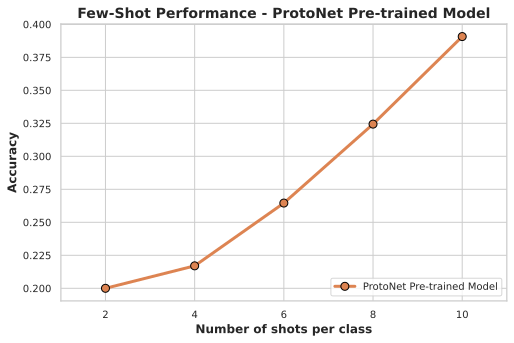

In [ ]:
ax = plot_few_shot(accuracies, name="ProtoNet Pre-trained Model", color="C1")
plt.show()
plt.close()

#Conclusion

The output of the model is the following : For each iteration of k shots :

*   Accuracy for k=2: 20.00% (+-3.33%)
*   Accuracy for k=4: 21.70% (+-8.76%)
*   Accuracy for k=6: 26.46% (+-6.78%)
*   Accuracy for k=8: 32.44% (+-6.19%)
*   Accuracy for k=10: 39.07% (+-10.86%)

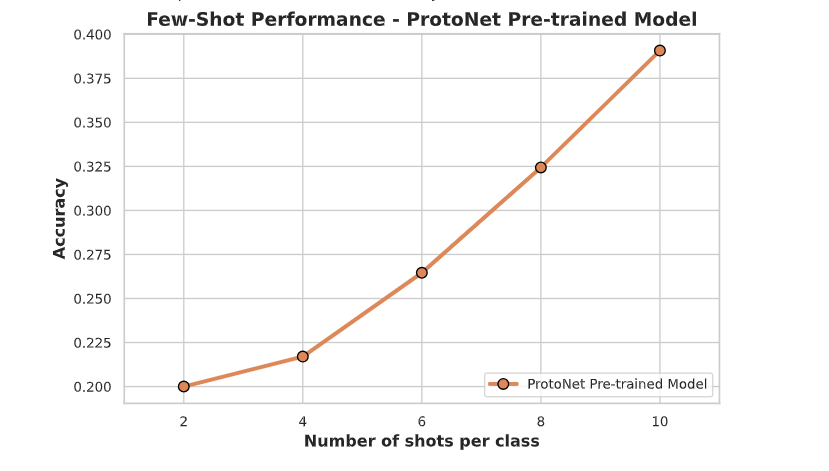

We observe here that the use of Protonet (a pre-trained meta-learner) achieved a remarkable accuracy of about 40% for a 6 way 10 shot learning environment.

This is much more than the random baseline of 16.5%.

One possible way in which this model could be improved would be by adding more shots for each class.

We also note that overall, the ProtoNet offers the most stable accuracy on the validation set. Indeed, the accuracy obtained here is 40% more steady, whereas for the models we have developed in Part 1 of the assignment, the accuracy can get as high as 50%, but the accuracy is more volatile to hyperparameter tuning.

All in all in this assignment, we attempted to create a 6 dimensional classifier using 20 samples per class. **This was an ambitious goal set, and we manage to achieve to reach a peak accuracy of 50 %. This is more than 3 times the random baseline we had set for our model.**

**Paths of improvement:**
- We could try to improve our model by adding more data to our model
- We can try to implement 1 vs all classifiers (simply classifing whether there is a defect or no)
- We can compare the performance of ProtoNet with other classifiers, and stack their predictions into another more powerful mode.
